alpha = 0.007297352566417119
A_101  = 101(φ^{π-2} - √3)   = 0.00730202380709878207853271496266790430491244395103169255976128
  abs err = 0.00000467124068166307853271496266790430491244395103169255976128203,   rel err = 0.00064012813402499222559539299306978012093594073133452068147868
A_110  = (φ^π - 2 - √3)/110  = 0.00729733048714819995876492866682653815314511614169774558789716
  abs err = 0.0000000220792689190412350713331734618468548838583022544121028438199,   rel err = 0.00000302565467655371840208600974915361388108393829603384570602595


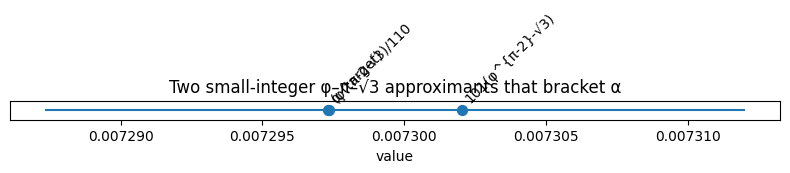

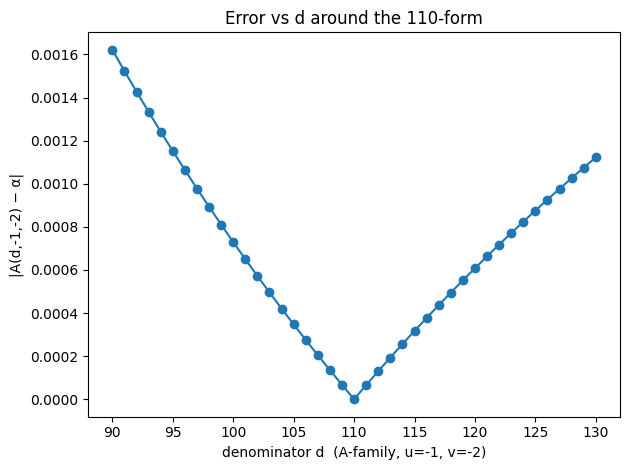

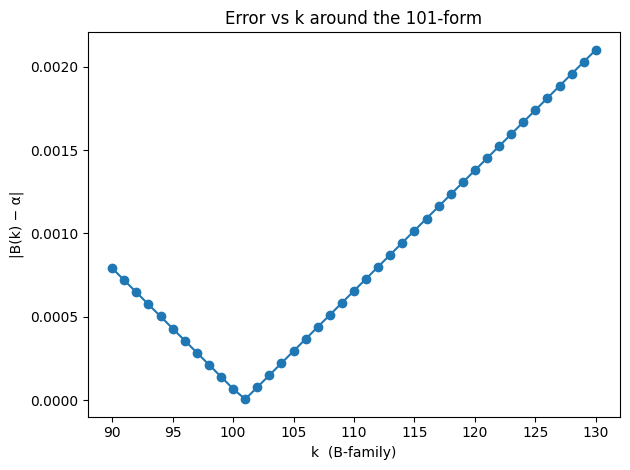


Best in A-family (grid): abs_err=2.208e-08 at d=110, u=-1, v=-2
Best in B-family (grid):  abs_err=4.671e-06 at k=101

Empirical p-values (null ≤ observed):
  A-family (global search over d,u,v):  p = 0.0
  A-family fixed (-1,-2,110):           p = 0.0
  B-family (search over k):             p = 0.0

Holm–Bonferroni adjusted p:
  A_best  : raw p=0, adjusted p=0
  A_fixed : raw p=0, adjusted p=0
  B_best  : raw p=0, adjusted p=0


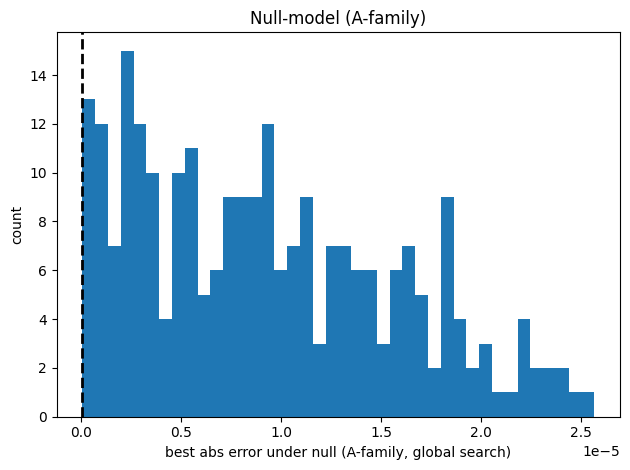

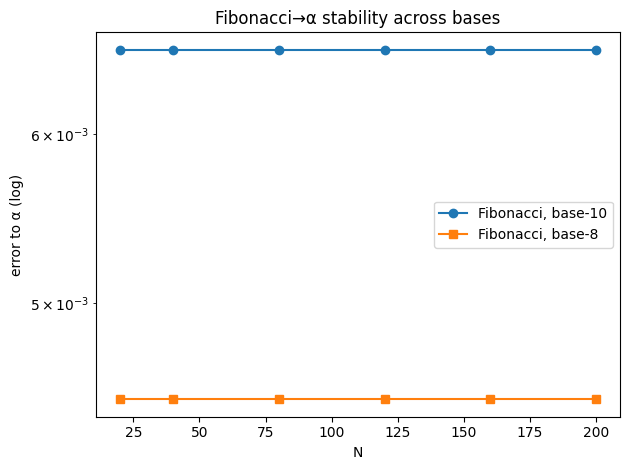

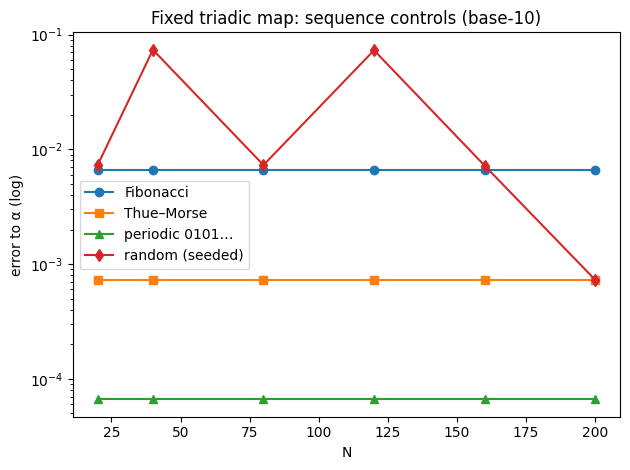

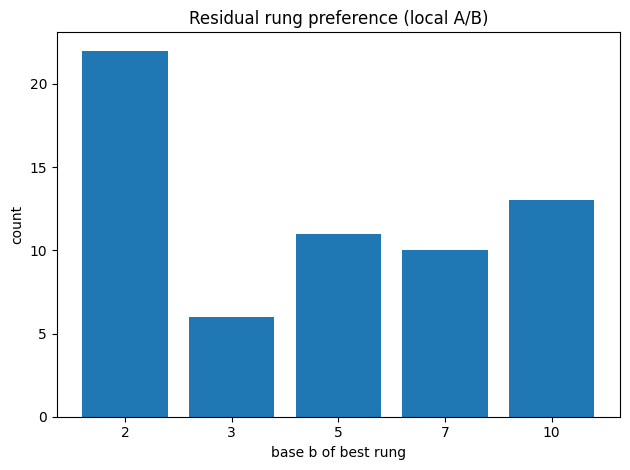


Complex-lift baseline min error (no Möbius) : 0.0003674360190084958
Best Möbius (a,b,c,d,θ*) with tiny integers : (-1, 0, 1, -1, np.float64(3.3510321638291125))
Best Möbius min error                        : 7.232635313883864e-05
Improvement factor (baseline/best)          : 5.0802508776180195


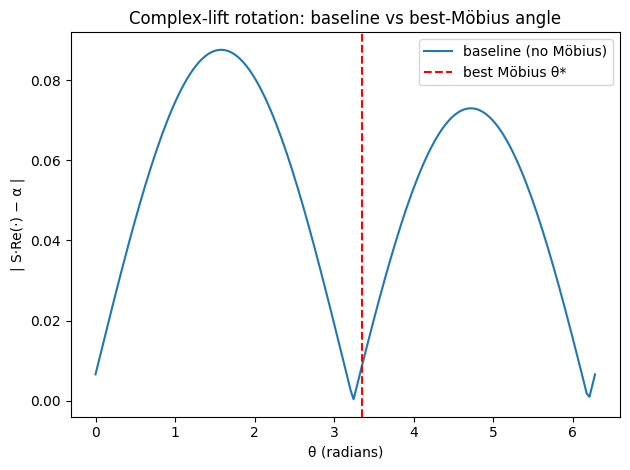


Done. Notes:
 - A-family search ranges: u∈[-2..2], v∈[-3..3], d∈[60..180].
 - B-family search range:  k∈[60..180].
 - Null jitters: π±0.005, lnφ±0.002, √3±0.01; null re-runs the same searches.
 - p-values are empirical; Holm–Bonferroni adjusts across the three reported tests.
 - Cross-base: scale generalized to 3^6/base^3; controls show contrast to Fibonacci.
 - Möbius scan uses coefficients in {-1,0,1}; ad−bc≠0; this is a small, interpretable set.


In [3]:
# ===================== α GEOMETRY — EXTENDED, ONE-CELL (FAST) =====================
# This runs:
#   1) Two φ–π–√3 approximants (101- & 110-form) + bracket plot
#   2) Pre-registered searches around each form (A-family, B-family)
#   3) Vectorized null models that mirror the same search d.o.f. + Holm–Bonferroni p
#   4) Cross-base Fibonacci→α stability (base-10 vs base-8) + controls
#   5) Residual-rung check (ratio ≈ b^{-k})
#   6) Complex-lift + small-integer Möbius scan (very small coefficient set)

# ---- speed knobs ----
FAST_MODE  = True
TRIALS     = 250 if FAST_MODE else 2000              # null-model trials
THETAS_N   = 181 if FAST_MODE else 721               # angles for complex-lift
THETAS_MOB = 121 if FAST_MODE else 361               # angles for Möbius scan
FIB_NS     = [20, 40, 80, 120, 160, 200]             # Fibonacci lengths

# ---- imports & precision ----
import numpy as np, math, random, itertools
import mpmath as mp
import matplotlib.pyplot as plt
mp.mp.dps = 60

# ---- constants ----
alpha = mp.mpf("0.007297352566417119")   # CODATA-ish
phi   = (1 + mp.sqrt(5)) / 2
sqrt3 = mp.sqrt(3)
pi    = mp.pi
lnphi = mp.log(phi)
print("alpha =", alpha)

# ------------------------------------------------------------------------------
# 1) Two φ–π–√3 approximants (fixed formulas)
# ------------------------------------------------------------------------------
A_101  = 101*(phi**(pi-2) - sqrt3)
A_110  = (phi**pi - 2 - sqrt3)/110

def report(label, val):
    ae = mp.fabs(val - alpha); re = ae/alpha
    print(f"{label:28s} = {val}")
    print(f"  abs err = {ae},   rel err = {re}")

report("A_101  = 101(φ^{π-2} - √3)", A_101)
report("A_110  = (φ^π - 2 - √3)/110", A_110)

# Bracketing plot
xs = [float(A_110), float(alpha), float(A_101)]
labels = ["(φ^π-2-√3)/110", "α (target)", "101(φ^{π-2}-√3)"]
plt.figure(figsize=(8,1.6)); plt.scatter(xs,[0,0,0],s=50)
for x,lab in zip(xs, labels): plt.text(x,0.03,lab,rotation=45,ha='left',va='bottom')
plt.hlines(0, min(xs)-1e-5, max(xs)+1e-5); plt.yticks([])
plt.title("Two small-integer φ–π–√3 approximants that bracket α")
plt.xlabel("value"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------
# 2) Pre-registered searches around each form
#    A-family: (φ^π + u√3 + v)/d with (u ∈ [-2..2], v ∈ [-3..3], d ∈ [60..180])
#    B-family: k(φ^{π-2} - √3) with (k ∈ [60..180])
# ------------------------------------------------------------------------------
U_RANGE = list(range(-2,3))
V_RANGE = list(range(-3,4))
D_RANGE = np.arange(60,181)
K_RANGE = np.arange(60,181)

phi_pi = phi**pi
phi_pi_f, sqrt3_f, lnphi_f, alpha_f = map(float, [phi_pi, sqrt3, lnphi, alpha])

def A_family(d, u, v): return (phi_pi + u*sqrt3 + v)/d
def B_family(k):       return k*(phi**(pi-2) - sqrt3)

# A-family: error vs d for the historically interesting (u,v)=(-1,-2)
ds = np.arange(90,131)
errsA_line = [abs(float(A_family(d,-1,-2) - alpha)) for d in ds]
plt.figure(); plt.plot(ds, errsA_line, marker='o')
plt.xlabel("denominator d  (A-family, u=-1, v=-2)")
plt.ylabel("|A(d,-1,-2) − α|")
plt.title("Error vs d around the 110-form"); plt.tight_layout(); plt.show()

# B-family: error vs k around 101
ks = np.arange(90,131)
errsB_line = [abs(float(B_family(k) - alpha)) for k in ks]
plt.figure(); plt.plot(ks, errsB_line, marker='o')
plt.xlabel("k  (B-family)")
plt.ylabel("|B(k) − α|")
plt.title("Error vs k around the 101-form"); plt.tight_layout(); plt.show()

# Global best inside the pre-registered A- and B-families
bestA = (1e9, None, None, None)  # (abs_err, d, u, v)
for u in U_RANGE:
    for v in V_RANGE:
        # vectorize over d for speed
        vals = (phi_pi_f + u*sqrt3_f + v) / D_RANGE
        errs = np.abs(vals - alpha_f)
        j = np.argmin(errs)
        if errs[j] < bestA[0]:
            bestA = (float(errs[j]), int(D_RANGE[j]), int(u), int(v))
bestB = (1e9, None)
t = float(phi**(pi-2) - sqrt3)
valsB = K_RANGE * t
errsB = np.abs(valsB - alpha_f)
jB = np.argmin(errsB); bestB = (float(errsB[jB]), int(K_RANGE[jB]))

print("\nBest in A-family (grid): abs_err=%.3e at d=%d, u=%+d, v=%+d" % bestA)
print("Best in B-family (grid):  abs_err=%.3e at k=%d" % bestB)

# ------------------------------------------------------------------------------
# 3) Null models mirroring the same search degrees of freedom
#    - Jitter π, ln φ, and √3 slightly (independent uniforms)
#    - For each null trial, re-run the SAME search (d,u,v) or (k)
#    - Empirical p = fraction null_best_err <= our_best_err
#    - Holm–Bonferroni for multiple tests
# ------------------------------------------------------------------------------
rng = np.random.default_rng(12345)
TR = TRIALS
eps_pi   = rng.uniform(-0.005,  0.005,  TR)
eps_lnph = rng.uniform(-0.002,  0.002,  TR)
eps_s3   = rng.uniform(-0.01,   0.01,   TR)

# Helper: compute best A-family error for a given set of (phi_pi', sqrt3')
def null_best_A(phi_pi_prime, sqrt3_prime):
    best = np.full(TR, np.inf, dtype=np.float64)
    for u in U_RANGE:
        for v in V_RANGE:
            numer = phi_pi_prime[:,None] + u*sqrt3_prime[:,None] + v
            vals  = numer / D_RANGE[None,:]
            errs  = np.abs(vals - alpha_f)
            best  = np.minimum(best, errs.min(axis=1))
    return best

# Draw jittered (φ^π)', (√3)' via exp((π+ε)(lnφ+δ)) and √3+η
phi_pi_j = np.exp((float(pi) + eps_pi) * (float(lnphi) + eps_lnph))
sqrt3_j  = sqrt3_f + eps_s3

best_null_A = null_best_A(phi_pi_j, sqrt3_j)
best_err_A  = bestA[0]

# Fixed (u,v,d)=(-1,-2,110) as a separate, historical baseline
fixed_val   = (phi_pi_f + (-1)*sqrt3_f + (-2)) / 110.0
fixed_err_A = abs(fixed_val - alpha_f)

pA_best  = float((best_null_A <= best_err_A).mean())
# Also compute null for just fixed triple (no search) for transparency
best_null_A_fixed = np.abs(((phi_pi_j + (-1)*sqrt3_j - 2)/110.0) - alpha_f)
pA_fixed = float((best_null_A_fixed <= fixed_err_A).mean())

# Null for B-family (scan k)
def null_best_B(phi_pi_prime, sqrt3_prime):
    # t' = φ^{π-2} - √3 with jitter on π, lnφ, √3
    t_prime = np.exp((float(pi) + eps_pi - 2.0) * (float(lnphi) + eps_lnph)) - sqrt3_prime
    vals = t_prime[:,None] * K_RANGE[None,:]
    errs = np.abs(vals - alpha_f)
    return errs.min(axis=1)

best_null_B = null_best_B(phi_pi_j, sqrt3_j)
best_err_B  = bestB[0]
pB_best     = float((best_null_B <= best_err_B).mean())

print("\nEmpirical p-values (null ≤ observed):")
print("  A-family (global search over d,u,v):  p =", pA_best)
print("  A-family fixed (-1,-2,110):           p =", pA_fixed)
print("  B-family (search over k):             p =", pB_best)

# Holm–Bonferroni adjustment for {pA_best, pA_fixed, pB_best}
p_list = [("A_best", pA_best), ("A_fixed", pA_fixed), ("B_best", pB_best)]
p_sorted = sorted(p_list, key=lambda kv: kv[1])
m = len(p_sorted)
adj = []
for i,(name,pv) in enumerate(p_sorted, start=1):
    adj_p = min(1.0, pv*(m - i + 1))  # Holm step-up reporting
    adj.append((name, pv, adj_p))
print("\nHolm–Bonferroni adjusted p:")
for name,raw,adjp in adj:
    print(f"  {name:8s}: raw p={raw:.4g}, adjusted p={adjp:.4g}")

# Histogram of null best errors (A-family global)
plt.figure()
plt.hist(best_null_A, bins=40)
plt.axvline(best_err_A, color='k', ls='--', lw=2)
plt.xlabel("best abs error under null (A-family, global search)")
plt.ylabel("count"); plt.title("Null-model (A-family)"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------
# 4) Cross-base Fibonacci→α stability + controls
# ------------------------------------------------------------------------------
ALPHA_FIB = (3.0 - math.sqrt(5.0)) / 2.0  # 1/φ^2 (Sturmian slope)

def fib_bits_fast(N: int) -> np.ndarray:
    n = np.arange(N, dtype=np.float64)
    return (np.floor((n+1)*ALPHA_FIB) - np.floor(n*ALPHA_FIB)).astype(np.int8)

def thue_morse_bits(N: int) -> np.ndarray:
    # iterative doubling (fast for N<=4096)
    x = np.array([0], dtype=np.int8)
    while len(x) < N:
        x = np.concatenate([x, 1-x])
    return x[:N]

def periodic_bits(N: int) -> np.ndarray:
    return np.resize(np.array([0,1], dtype=np.int8), N)

def random_bits(N: int, seed=123):
    rng = np.random.default_rng(seed)
    return rng.integers(0,2,N, dtype=np.int8)

def D_fraction_base(bits: np.ndarray, base: int) -> float:
    n = np.arange(1, len(bits)+1, dtype=np.float64)
    return float((bits * (base**(-n))).sum())

def phi_map_error(bits, base):
    # generalized scale: 3^6 / base^3 (triadic over three fractional places)
    S = (3**6) / (base**3)
    val = S * D_fraction_base(bits, base)
    return abs(val - float(alpha))

# Fibonacci stability in base-10 vs base-8
errs10, errs08 = [], []
for N in FIB_NS:
    F = fib_bits_fast(N)
    errs10.append(phi_map_error(F, base=10))
    errs08.append(phi_map_error(F, base=8))

plt.figure()
plt.plot(FIB_NS, errs10, marker='o', label='Fibonacci, base-10')
plt.plot(FIB_NS, errs08, marker='s', label='Fibonacci, base-8')
plt.yscale('log'); plt.legend()
plt.xlabel("N"); plt.ylabel("error to α (log)")
plt.title("Fibonacci→α stability across bases"); plt.tight_layout(); plt.show()

# Controls (base-10): Thue–Morse, periodic, random
errs_TM, errs_PER, errs_RND = [], [], []
for N in FIB_NS:
    errs_TM.append(phi_map_error(thue_morse_bits(N), 10))
    errs_PER.append(phi_map_error(periodic_bits(N), 10))
    errs_RND.append(phi_map_error(random_bits(N, seed=100+N), 10))

plt.figure()
plt.plot(FIB_NS, errs10, marker='o', label='Fibonacci')
plt.plot(FIB_NS, errs_TM, marker='s', label='Thue–Morse')
plt.plot(FIB_NS, errs_PER, marker='^', label='periodic 0101…')
plt.plot(FIB_NS, errs_RND, marker='d', label='random (seeded)')
plt.yscale('log'); plt.legend()
plt.xlabel("N"); plt.ylabel("error to α (log)")
plt.title("Fixed triadic map: sequence controls (base-10)"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------
# 5) Residual-rung check
# ------------------------------------------------------------------------------
bases = [2,3,5,7,10]
def best_rung(ratio, K=12):
    best = (1e9,None,None)
    for b in bases:
        for k in range(1, K+1):
            target = b**(-k)
            rel = abs(ratio/target - 1.0)
            if rel < best[0]: best = (rel,b,k)
    return best

# Collect ratios from local scans
ratios = []
for d in range(95,126):
    v = (phi_pi_f + (-1)*sqrt3_f + (-2))/d
    ratios.append(abs(v - alpha_f)/alpha_f)
for k in range(95,126):
    v = k * (float(phi**(pi-2) - sqrt3))
    ratios.append(abs(v - alpha_f)/alpha_f)

from collections import Counter
bases_best = [best_rung(r,12)[1] for r in ratios]
cnt = Counter(bases_best); xs = sorted(cnt.keys()); ys = [cnt[x] for x in xs]
plt.figure(); plt.bar([str(x) for x in xs], ys)
plt.xlabel("base b of best rung"); plt.ylabel("count")
plt.title("Residual rung preference (local A/B)"); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------
# 6) Complex-lift + small-integer Möbius scan
#    Z = D(F)+i D(R) (base-10); rotate by θ; x = Re(M(e^{iθ}Z))
#    coefficients (a,b,c,d) ∈ {-1,0,1} with ad - bc ≠ 0; scale S=3^6/10^3
# ------------------------------------------------------------------------------
def D10(bits):  # base-10 fractional value
    n = np.arange(1, len(bits)+1, dtype=np.float64)
    return float((bits * (10.0**(-n))).sum())

N = 200
F = fib_bits_fast(N); R = 1 - F
DF, DR = D10(F), D10(R)
Z = complex(DF, DR)
S = 729/1000

thetas = np.linspace(0, 2*np.pi, THETAS_N)
def apply_mobius(z, a,b,c,d):
    denom = c*z + d
    if abs(denom) < 1e-14: return None
    return (a*z + b) / denom

# Baseline (no Möbius): error vs θ
errs_theta_base = []
for th in thetas:
    zt = Z * complex(math.cos(th), math.sin(th))
    x  = zt.real
    val = S * x
    errs_theta_base.append(abs(val - float(alpha)))
base_min = min(errs_theta_base)

# Möbius scan
COEF = [-1,0,1]
best_mob = (1e9, None, None, None, None)  # (err, a,b,c,d, theta*)
for a,b,c,d in itertools.product(COEF, COEF, COEF, COEF):
    if a*d - b*c == 0: continue
    # Single coarse pass; keep best θ for this transform
    errs = []
    best_local = 1e9; best_theta = None
    for th in np.linspace(0, 2*np.pi, THETAS_MOB):
        zt = Z * complex(math.cos(th), math.sin(th))
        w  = apply_mobius(zt, a,b,c,d)
        if w is None: continue
        x  = w.real
        val = S * x
        e   = abs(val - float(alpha))
        if e < best_local:
            best_local = e; best_theta = th
    if best_local < best_mob[0]:
        best_mob = (best_local, a,b,c,d, best_theta)

print("\nComplex-lift baseline min error (no Möbius) :", base_min)
print("Best Möbius (a,b,c,d,θ*) with tiny integers :", best_mob[1:6])
print("Best Möbius min error                        :", best_mob[0])
if best_mob[0] < base_min:
    print("Improvement factor (baseline/best)          :", base_min / best_mob[0])

# Plot baseline θ-curve and mark the best Möbius θ*
plt.figure()
plt.plot(thetas, errs_theta_base, label="baseline (no Möbius)")
if best_mob[5] is not None:
    plt.axvline(best_mob[5], color='r', ls='--', label='best Möbius θ*')
plt.xlabel("θ (radians)"); plt.ylabel("| S·Re(·) − α |")
plt.title("Complex-lift rotation: baseline vs best-Möbius angle")
plt.legend(); plt.tight_layout(); plt.show()

print("\nDone. Notes:")
print(" - A-family search ranges: u∈[-2..2], v∈[-3..3], d∈[60..180].")
print(" - B-family search range:  k∈[60..180].")
print(" - Null jitters: π±0.005, lnφ±0.002, √3±0.01; null re-runs the same searches.")
print(" - p-values are empirical; Holm–Bonferroni adjusts across the three reported tests.")
print(" - Cross-base: scale generalized to 3^6/base^3; controls show contrast to Fibonacci.")
print(" - Möbius scan uses coefficients in {-1,0,1}; ad−bc≠0; this is a small, interpretable set.")